<a href="https://colab.research.google.com/github/junaina/EmpathAI/blob/preview-warda-wip/EmpathAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
!pip install transformers datasets nltk

from datasets import load_dataset
import pandas as pd

dataset=load_dataset("go_emotions")
df=dataset["train"].to_pandas()

# filter out stuff with no labels
df=df[df['labels'].map(len)>0]
df["label"]=df["labels"].apply(lambda x:x[0])
label_names_full=dataset["train"].features["labels"].feature.names
df["emotion"]=df["label"].apply(lambda x:label_names_full[x])
df=df[["text","label","emotion"]].rename(columns={"text":"clean_text"})

# mapping into broader 5-class emotions
label_mapping={
  "joy":"joy","amusement":"joy","excitement":"joy","gratitude":"joy",
  "relief":"joy","pride":"joy","optimism":"joy","admiration":"joy",
  "sadness":"sad","disappointment":"sad","grief":"sad","remorse":"sad",
  "anger":"anger","annoyance":"anger","disapproval":"anger","embarrassment":"anger",
  "fear":"fear","nervousness":"fear","confusion":"fear",
  "love":"love","caring":"love","desire":"love",
  "surprise":"surprise","realization":"surprise","curiosity":"surprise"
}

df=df[df["emotion"].isin(label_mapping.keys())]
df["emotion"]=df["emotion"].map(label_mapping)

from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
df["label"]=label_encoder.fit_transform(df["emotion"])

X=list(df["clean_text"])
y=df["label"]


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer
import tensorflow as tf
import json

tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
tokens=tokenizer(X,truncation=True,padding=True,return_tensors='tf',max_length=128)

num_classes=len(label_encoder.classes_)

model=TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

batch_size=32
epochs=3
steps_per_epoch=len(X)//batch_size
num_train_steps=steps_per_epoch*epochs
num_warmup_steps=int(0.1*num_train_steps)

optimizer,_=create_optimizer(
  init_lr=2e-5,
  num_warmup_steps=num_warmup_steps,
  num_train_steps=num_train_steps
)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

# let's goooo
history=model.fit(
  x=dict(tokens),
  y=y,
  epochs=3,
  batch_size=16,
  validation_split=0.1
)

# dump everything so we can load it later
model.save_pretrained("bert_emotion_model")
tokenizer.save_pretrained("bert_emotion_model")

with open("bert_emotion_model/label_names.json","w") as f:
  json.dump(list(label_encoder.classes_),f)

import shutil
shutil.make_archive("bert_emotion_model",'zip',"bert_emotion_model")

from google.colab import files
files.download("bert_emotion_model.zip")


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
  24/1542 [..............................] - ETA: 6:59:13 - loss: 1.7814 - accuracy: 0.1224

In [62]:
import json
from transformers import TFBertForSequenceClassification, BertTokenizer
import tensorflow as tf
import pandas as pd
from nltk.tokenize import sent_tokenize
from collections import Counter
from datetime import datetime
import random
import nltk

nltk.download('punkt')

# Load model & tokenizer
model = TFBertForSequenceClassification.from_pretrained("./bert_emotion_model")
tokenizer = BertTokenizer.from_pretrained("./bert_emotion_model")

# Load label names
with open("bert_emotion_model/label_names.json", "r") as f:
    label_names = json.load(f)

# Prediction function
def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=128)
    outputs = model(inputs)
    predicted_class = tf.argmax(outputs.logits, axis=1).numpy()[0]
    emotion = label_encoder.inverse_transform([predicted_class])[0]
    confidence = tf.nn.softmax(outputs.logits, axis=1)[0][predicted_class].numpy()
    return emotion, round(confidence * 100, 2)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some layers from the model checkpoint at ./bert_emotion_model were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./bert_emotion_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification 

In [63]:
# a lil pocket of good vibes
motivational_responses={
  "joy":[
    "Embrace the joy—your light is infectious!",
    "Let your smile fuel someone else's day.",
    "Happiness looks good on you—don’t let it go.",
    "You’re in a beautiful moment—savor it.",
    "Joy is contagious—spread it freely.",
    "You deserve every bit of this happiness.",
    "The world feels lighter when you smile.",
    "Anchor yourself in this feeling—it’s real."
  ],
  "anger":[
    "You have the right to feel this—breathe.",
    "You can rise above this.",
    "Let your fire fuel growth, not destruction.",
    "Channel that energy into something meaningful.",
    "Take a moment. You’re allowed to feel upset.",
    "You’re not defined by this anger.",
    "Even the storm has purpose—just don't let it drown you.",
    "Sometimes silence is the most powerful response."
  ],
  "fear":[
    "Courage means acting even when afraid.",
    "You are stronger than your fears.",
    "One step at a time—you’re doing better than you think.",
    "Fear is part of growth—lean into it.",
    "You’ve survived tough moments before. You will again.",
    "This feeling will pass—breathe through it.",
    "You’re not alone in this.",
    "Trust yourself—you’ve got this."
  ],
  "love":[
    "Your love makes the world better.",
    "You’re deeply valued and appreciated.",
    "The kindness you give comes back tenfold.",
    "Love is your strength—don’t hide it.",
    "You carry warmth that others feel even in silence.",
    "You are love in motion—keep going.",
    "Stay open—it’s your superpower.",
    "You're someone’s reason to believe in good."
  ],
  "surprise":[
    "Sometimes surprises lead to new beginnings.",
    "Let curiosity guide your next step.",
    "Life’s unexpected turns often carry hidden gifts.",
    "Stay open—wonder lives in the unknown.",
    "Not all surprises are setbacks—some are setups.",
    "Trust that the shift is leading somewhere meaningful.",
    "You’re writing a story even you don’t know the end of yet.",
    "Let awe be your compass when the road bends."
  ]
}

def get_motivational_response(emotion):
  return random.choice(
    motivational_responses.get(emotion.lower(),
    ["I'm here for you, no matter what you're feeling."])
  )


In [70]:
# mood journal (only if not already hangin' around)
if 'mood_log' not in globals():
  mood_log = pd.DataFrame(columns=[
    "Timestamp",
    "User Input",
    "Predicted Emotion",
    "Motivational Response"
  ])

# save but only when *you* say so
def download_mood_log(filename="mood_tracker_log.csv"):
  if not mood_log.empty:
    mood_log.to_csv(filename, index=False)
    from google.colab import files
    files.download(filename)

# main thing: break down a paragraph, feel it, respond to it
def analyze_paragraph(paragraph):
  sentences = sent_tokenize(paragraph)
  results = []

  print("🔍 Sentence-wise predictions:\n")

  for sent in sentences:
    emotion, confidence = predict_emotion(sent)
    results.append(emotion)
    print(f"• {sent.strip()} → {emotion} ({confidence:.2f}%)")

  counts = Counter(results)
  top_count = counts.most_common(1)[0][1]
  tied = [e for e, c in counts.items() if c == top_count]
  dominant = tied[0]  # pick the top one even if tie

  print(f"\n Dominant emotion: {dominant}")
  response = get_motivational_response(dominant)
  print("💬 Empath says:", response)

  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  # record
  global mood_log
  mood_log = pd.concat([mood_log, pd.DataFrame([{
    "Timestamp": timestamp,
    "User Input": paragraph,
    "Predicted Emotion": dominant,
    "Motivational Response": response
  }])], ignore_index=True)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 38)

In [ ]:
download_mood_log()


In [71]:
paragraphs = [
    "Lately, I wake up feeling heavy, like there's a cloud hovering over me. I can't explain why, but I feel so empty.",
    "Every little thing makes me anxious. My hands shake before I even open my emails. I don't know how long I can keep this up.",
    "The silence in my room is too loud these days. I used to enjoy being alone, but now it just feels lonely and sad.",
    "I feel like a burden to everyone around me. I smile in front of them, but inside I'm falling apart.",
]
paragraphs += [
    "Why do people never listen until you're yelling? I'm sick of being calm while others walk all over me.",
    "Everything around me feels unfair. I'm trying so hard, but no one seems to care or acknowledge it.",
]
paragraphs += [
    "I watched the sunset today, and for a moment, all my worries disappeared. It was peaceful, beautiful, and grounding.",
    "My best friend surprised me with my favorite coffee today. I don’t know what I’d do without them. My heart feels full.",
    "There’s something about dancing alone in your room that makes you feel so alive. I felt free today.",
]
paragraphs += [
    "I thought today would be ordinary, but out of nowhere, an old friend called and we talked for hours. Totally unexpected and comforting.",
]
for p in paragraphs:
    analyze_paragraph(p)


🔍 Sentence-wise predictions:

• Lately, I wake up feeling heavy, like there's a cloud hovering over me. → sad (70.34%)
• I can't explain why, but I feel so empty. → sad (76.86%)

 Dominant emotion: sad
💬 Empath says: I'm here for you, no matter what you're feeling.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🔍 Sentence-wise predictions:

• Every little thing makes me anxious. → fear (79.98%)
• My hands shake before I even open my emails. → fear (57.34%)
• I don't know how long I can keep this up. → fear (89.29%)

 Dominant emotion: fear
💬 Empath says: Courage means acting even when afraid.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🔍 Sentence-wise predictions:

• The silence in my room is too loud these days. → anger (40.12%)
• I used to enjoy being alone, but now it just feels lonely and sad. → sad (91.85%)

 Dominant emotion: anger
💬 Empath says: Channel that energy into something meaningful.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🔍 Sentence-wise predictions:

• I feel like a burden to everyone around me. → sad (92.77%)
• I smile in front of them, but inside I'm falling apart. → sad (90.14%)

 Dominant emotion: sad
💬 Empath says: I'm here for you, no matter what you're feeling.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🔍 Sentence-wise predictions:

• Why do people never listen until you're yelling? → surprise (46.96%)
• I'm sick of being calm while others walk all over me. → anger (74.65%)

 Dominant emotion: surprise
💬 Empath says: Life’s unexpected turns often carry hidden gifts.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🔍 Sentence-wise predictions:

• Everything around me feels unfair. → anger (88.77%)
• I'm trying so hard, but no one seems to care or acknowledge it. → sad (66.33%)

 Dominant emotion: anger
💬 Empath says: Sometimes silence is the most powerful response.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🔍 Sentence-wise predictions:

• I watched the sunset today, and for a moment, all my worries disappeared. → sad (29.27%)
• It was peaceful, beautiful, and grounding. → joy (97.84%)

 Dominant emotion: sad
💬 Empath says: I'm here for you, no matter what you're feeling.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🔍 Sentence-wise predictions:

• My best friend surprised me with my favorite coffee today. → surprise (68.77%)
• I don’t know what I’d do without them. → fear (88.85%)
• My heart feels full. → joy (79.55%)

 Dominant emotion: surprise
💬 Empath says: Not all surprises are setbacks—some are setups.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🔍 Sentence-wise predictions:

• There’s something about dancing alone in your room that makes you feel so alive. → joy (55.13%)
• I felt free today. → joy (93.89%)

 Dominant emotion: joy
💬 Empath says: Anchor yourself in this feeling—it’s real.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🔍 Sentence-wise predictions:

• I thought today would be ordinary, but out of nowhere, an old friend called and we talked for hours. → surprise (49.56%)
• Totally unexpected and comforting. → joy (86.85%)

 Dominant emotion: surprise
💬 Empath says: You’re writing a story even you don’t know the end of yet.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1200x600 with 0 Axes>

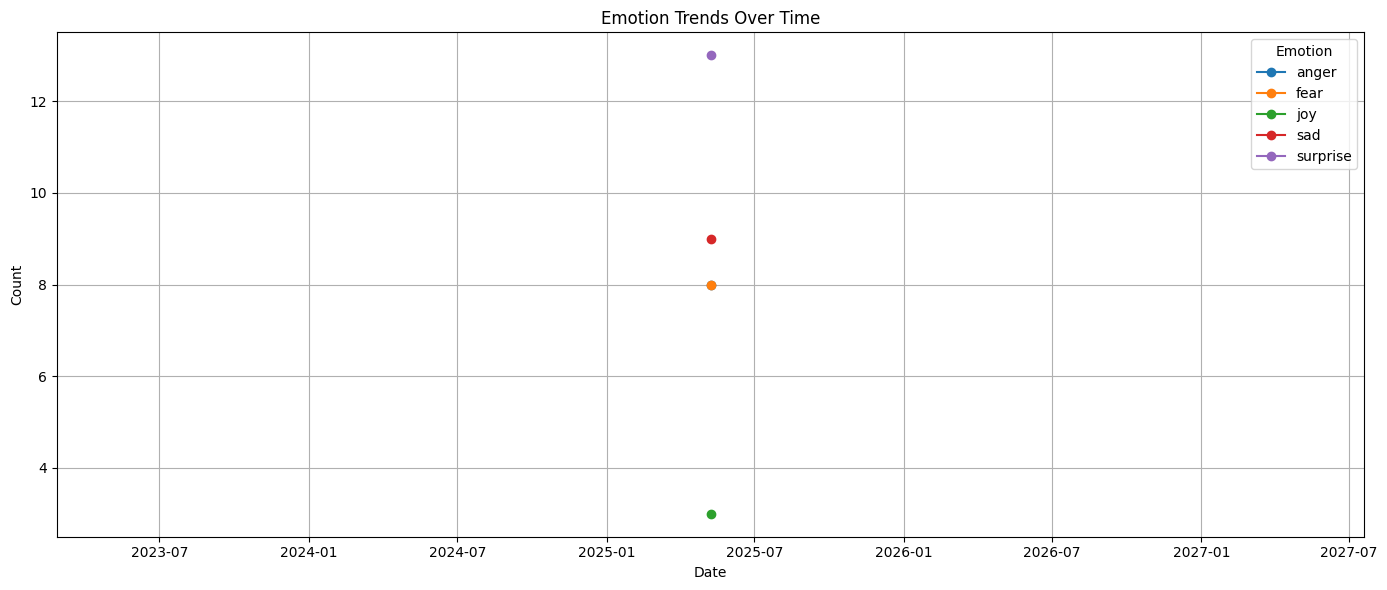

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# grab the log we’ve been building
log_df = pd.read_csv("mood_tracker_log.csv")

# make sure the timestamps behave
log_df["Timestamp"] = pd.to_datetime(log_df["Timestamp"])
log_df["Date"] = log_df["Timestamp"].dt.date  # or .dt.floor("D") for more control

# how often each emotion popped up per day
emotion_counts = log_df.groupby(["Date", "Predicted Emotion"]).size().unstack(fill_value=0)

# visualization
plt.figure(figsize=(12,6))
emotion_counts.plot(kind="line", marker="o", figsize=(14,6))
plt.title("📈 Emotion Trends Over Time")
plt.xlabel("🗓️ Date")
plt.ylabel("🧠 Emotion Count")
plt.legend(title="Emotion")
plt.grid(True)
plt.tight_layout()
plt.show()
